#START 
dependencies

In [ ]:
pip -q install transformers datasets    

     |████████████████████████████████| 3.5 MB 9.3 MB/s 
     |████████████████████████████████| 311 kB 87.5 MB/s 
     |████████████████████████████████| 596 kB 82.5 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 895 kB 78.4 MB/s 
     |████████████████████████████████| 6.8 MB 51.9 MB/s 
     |████████████████████████████████| 1.1 MB 72.1 MB/s 
     |████████████████████████████████| 133 kB 95.6 MB/s 
     |████████████████████████████████| 243 kB 91.5 MB/s 
     |████████████████████████████████| 94 kB 691 kB/s 
     |████████████████████████████████| 144 kB 44.8 MB/s 
     |████████████████████████████████| 271 kB 64.6 MB/s 


In [ ]:
!nvidia-smi

Wed Feb  9 10:21:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# load tensorboard extension
%load_ext tensorboard

# Patronizing and Condescending Language Detection

Baselines from [the paper](https://arxiv.org/pdf/2011.08320.pdf):


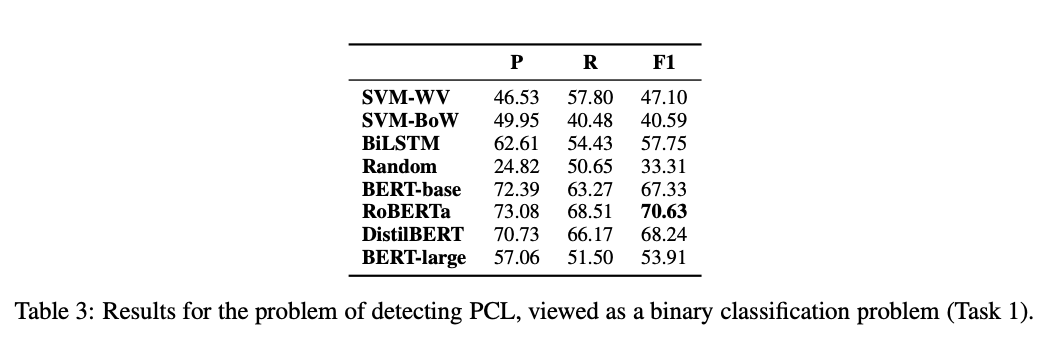


## Prepare Dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!wget https://gist.githubusercontent.com/Sirwe-Saeedi/eff6f35a0aa182c2043da977e3a55171/raw/1865bd29a8a8c16580fec55f084316ed92d34950/TrainingSet_EvaluationPhase.csv

--2022-02-09 10:21:13--  https://gist.githubusercontent.com/Sirwe-Saeedi/eff6f35a0aa182c2043da977e3a55171/raw/1865bd29a8a8c16580fec55f084316ed92d34950/TrainingSet_EvaluationPhase.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3122842 (3.0M) [text/plain]
Saving to: ‘TrainingSet_EvaluationPhase.csv’

TrainingSet_Evaluat 100%[===================>]   2.98M  --.-KB/s    in 0.04s   

2022-02-09 10:21:13 (76.2 MB/s) - ‘TrainingSet_EvaluationPhase.csv’ saved [3122842/3122842]



In [ ]:
#Skip the disclaimer at the beginning of file
df_pcl = pd.read_csv('./TrainingSet_EvaluationPhase.csv', sep='\t', skiprows=4, header = None)
df_pcl.columns = ['index','paragraph_id',	'keyword', 'country_code',	'paragraph', 'label']
df_pcl.drop('index', axis = 1, inplace=True)
df_pcl

,paragraph_id,keyword,country_code,paragraph,label
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0
...,...,...,...,...,...
10464,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1
10465,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0
10466,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3
10467,@@16753236,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4


In [ ]:
df_pcl['keyword'].value_counts('')

migrant          1089
in-need          1082
vulnerable       1080
homeless         1077
women            1070
refugee          1068
immigrant        1061
disabled         1028
hopeless         1005
poor-families     909
Name: keyword, dtype: int64

In [ ]:
df_pcl['paragraph_id'].duplicated().value_counts()

False    10093
True       376
Name: paragraph_id, dtype: int64

Note that none of the duplicated paragraph_ids has matching paragraph text. So we don't have any issue in this regard.

In [ ]:
df_pcl[df_pcl['paragraph_id'].duplicated()][df_pcl['paragraph_id'] == '@@1958113']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,paragraph_id,keyword,country_code,paragraph,label
419,@@1958113,homeless,tz,A new Dar es Salaam master plan which has just...,0
9854,@@1958113,homeless,tz,"Last week , many Dar es Salaam residents were ...",0


#Test set

In [ ]:
!wget https://gist.githubusercontent.com/Sirwe-Saeedi/f04bd684ad7b43f09934658c096dc475/raw/4128a99896080a84a61fccb73d58f82eb06a3b87/TestSet_EvaluationPhase.csv

--2022-02-09 10:21:14--  https://gist.githubusercontent.com/Sirwe-Saeedi/f04bd684ad7b43f09934658c096dc475/raw/4128a99896080a84a61fccb73d58f82eb06a3b87/TestSet_EvaluationPhase.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145277 (1.1M) [text/plain]
Saving to: ‘TestSet_EvaluationPhase.csv’

TestSet_EvaluationP 100%[===================>]   1.09M  --.-KB/s    in 0.04s   

2022-02-09 10:21:14 (28.8 MB/s) - ‘TestSet_EvaluationPhase.csv’ saved [1145277/1145277]



In [ ]:
df_pcl_test = pd.read_csv('./TestSet_EvaluationPhase.csv', sep='\t', header = None)
df_pcl_test.columns = ['index','paragraph_id',	'keyword', 'country_code',	'paragraph']
#df_pcl_test.drop('index', axis = 1, inplace=True)
df_pcl_test

,index,paragraph_id,keyword,country_code,paragraph
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to..."
1,t_1,@@16397324,women,pk,In most poor households with no education chil...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C..."
...,...,...,...,...,...
3827,t_3893,@@20319448,migrant,jm,In a letter dated Thursday to European Commiss...
3828,t_3894,@@9990672,poor-families,au,They discovered that poor families with health...
3829,t_3895,@@37984,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina..."
3830,t_3896,@@9691377,immigrant,us,The United Kingdom is n't going to devolve int...


## Binary Classification


In [ ]:
import os
# os.environ['WANDB_PROJECT'] = 'pcl-binary'

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import RobertaTokenizer, BertTokenizer
from torch.utils.data import TensorDataset

from transformers import RobertaForSequenceClassification, BertForSequenceClassification

import seaborn as sns

In [ ]:
len(df_pcl), len(df_pcl_test) 

(10469, 3832)

#Is there one null in paragraph column
drop it. so the df_pcl length is 10468.

In [ ]:
df_pcl.isnull().sum()

paragraph_id    0
keyword         0
country_code    0
paragraph       1
label           0
dtype: int64

In [ ]:
df_pcl = df_pcl.dropna().reset_index()
df_pcl.isnull().sum()

index           0
paragraph_id    0
keyword         0
country_code    0
paragraph       0
label           0
dtype: int64

In [ ]:
len(df_pcl)

10468

In [ ]:
df_pcl_test.isnull().sum()

index           0
paragraph_id    0
keyword         0
country_code    0
paragraph       0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


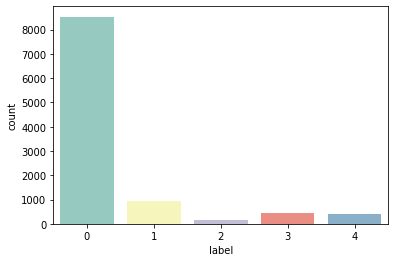

In [ ]:
s1 = sns.countplot(df_pcl['label'], palette="Set3");

In [ ]:
import matplotlib.pyplot as plt
fig = s1.get_figure()
fig.savefig('First-Imbalance-dataset.pdf')  

#[0,1,2,3,4] --> [0,1]
From [the paper](https://arxiv.org/pdf/2011.08320.pdf):


> for Task 1 we view paragraphs labelled with 0 or 1 as negative examples, and the remaining paragraphs, labelled with 2, 3 or 4, as positive examples



In [ ]:
df_pcl['labels'] = 0
df_pcl.loc[df_pcl.label.isin([2,3,4]), 'labels'] = 1 
df_pcl.drop('index', axis=1, inplace=True)
df_pcl

,paragraph_id,keyword,country_code,paragraph,label,labels
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0
3,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0
...,...,...,...,...,...,...
10463,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0
10464,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10465,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3,1
10466,@@16753236,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


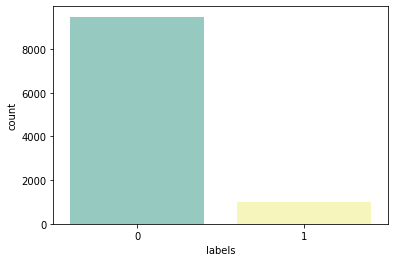

In [ ]:
s2 = sns.countplot(df_pcl['labels'], palette="Set3");

In [ ]:
import matplotlib.pyplot as plt
fig = s2.get_figure()
fig.savefig('Combined-labels-Imbalance-dataset.pdf')  

In [ ]:
df_pcl['labels'].sum()/len(df_pcl)    #number of data with lable 1 -->993 and 10468-993=9475 label 0

#df_pcl['paragraph'] = [df_pcl['paragraph'][i].replace('<h>', '') for i in range(10468)] makes it worse

0.09486052732136034

# Training using Huggingface API

##Combined Features for Training set

In [ ]:
def combine_features(row) :
  return '</s>'.join(row.drop(['labels','label'],axis=0).apply(str).values)
df_pcl['combined_features'] = df_pcl.apply(combine_features, axis = 1)
# df_pcl = df_pcl[['combined_features','labels']]
df_pcl.head(10)

,paragraph_id,keyword,country_code,paragraph,label,labels,combined_features
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,@@24942188</s>hopeless</s>ph</s>We 're living ...
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,@@21968160</s>migrant</s>gh</s>In Libya today ...
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0,@@16584954</s>immigrant</s>ie</s>White House p...
3,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0,@@7811231</s>disabled</s>nz</s>Council custome...
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0,"@@1494111</s>refugee</s>ca</s>"" Just like we r..."
5,@@9382277,in-need,in,"To bring down high blood sugar levels , insuli...",0,0,@@9382277</s>in-need</s>in</s>To bring down hi...
6,@@7562079,refugee,za,The European Union is making an historic mista...,0,0,@@7562079</s>refugee</s>za</s>The European Uni...
7,@@23663488,hopeless,nz,""" They 're either hopeless for being beaten by...",0,0,"@@23663488</s>hopeless</s>nz</s>"" They 're eit..."
8,@@3449225,homeless,ph,"NUEVA ERA , Ilocos Norte - No family shall be ...",1,0,"@@3449225</s>homeless</s>ph</s>NUEVA ERA , Ilo..."
9,@@2485090,in-need,nz,His spokesman said the Kremlin needed more inf...,0,0,@@2485090</s>in-need</s>nz</s>His spokesman sa...


In [ ]:
len(df_pcl)

10468

In [ ]:
df_pcl_train = df_pcl
df_pcl_train

,paragraph_id,keyword,country_code,paragraph,label,labels,combined_features
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,@@24942188</s>hopeless</s>ph</s>We 're living ...
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,@@21968160</s>migrant</s>gh</s>In Libya today ...
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0,@@16584954</s>immigrant</s>ie</s>White House p...
3,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0,@@7811231</s>disabled</s>nz</s>Council custome...
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0,"@@1494111</s>refugee</s>ca</s>"" Just like we r..."
...,...,...,...,...,...,...,...
10463,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0,@@14297363</s>women</s>lk</s>Sri Lankan norms ...
10464,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0,@@70091353</s>vulnerable</s>ph</s>He added tha...
10465,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3,1,"@@20282330</s>in-need</s>ng</s>"" She has one h..."
10466,@@16753236,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4,1,"@@16753236</s>hopeless</s>in</s>"" Anja Ringgre..."


##Combined features for test set

In [ ]:
def combine_features(row) :
  return '</s>'.join(row.drop(['index'],axis=0).apply(str).values)
df_pcl_test['combined_features'] = df_pcl_test.apply(combine_features, axis = 1)
df_pcl_test.head(10)

,index,paragraph_id,keyword,country_code,paragraph,combined_features
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to...",@@7258997</s>vulnerable</s>us</s>In the meanti...
1,t_1,@@16397324,women,pk,In most poor households with no education chil...,@@16397324</s>women</s>pk</s>In most poor hous...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...,@@16257812</s>migrant</s>ca</s>The real questi...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population...","@@3509652</s>migrant</s>gb</s>In total , the c..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C...",@@477506</s>vulnerable</s>ca</s>Members of the...
5,t_5,@@1797863,women,tz,"To ensure that "" Priority Agriculture Programm...","@@1797863</s>women</s>tz</s>To ensure that "" P..."
6,t_6,@@17227791,immigrant,us,The deportees stepped off their flight from El...,@@17227791</s>immigrant</s>us</s>The deportees...
7,t_7,@@8213205,disabled,pk,PIMS staffer who raped disabled girl at ICU wa...,@@8213205</s>disabled</s>pk</s>PIMS staffer wh...
8,t_9,@@1750742,vulnerable,lk,"I conclude , Yes , the general FEELING generat...","@@1750742</s>vulnerable</s>lk</s>I conclude , ..."
9,t_10,@@21002471,women,ke,After enduring discrimination in the all-male ...,@@21002471</s>women</s>ke</s>After enduring di...


In [ ]:
df_pcl_test

,index,paragraph_id,keyword,country_code,paragraph,combined_features
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to...",@@7258997</s>vulnerable</s>us</s>In the meanti...
1,t_1,@@16397324,women,pk,In most poor households with no education chil...,@@16397324</s>women</s>pk</s>In most poor hous...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...,@@16257812</s>migrant</s>ca</s>The real questi...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population...","@@3509652</s>migrant</s>gb</s>In total , the c..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C...",@@477506</s>vulnerable</s>ca</s>Members of the...
...,...,...,...,...,...,...
3827,t_3893,@@20319448,migrant,jm,In a letter dated Thursday to European Commiss...,@@20319448</s>migrant</s>jm</s>In a letter dat...
3828,t_3894,@@9990672,poor-families,au,They discovered that poor families with health...,@@9990672</s>poor-families</s>au</s>They disco...
3829,t_3895,@@37984,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina...",@@37984</s>migrant</s>ca</s>She married at 19 ...
3830,t_3896,@@9691377,immigrant,us,The United Kingdom is n't going to devolve int...,@@9691377</s>immigrant</s>us</s>The United Kin...


#Validation set

In [ ]:
np.random.seed(101)

In [ ]:
valid_size = 1000
# duplicate = df_pcl_selected[df_pcl['paragraph'].duplicated()]  #There is no duplicate
# none_duplicate = df_pcl_selected.drop(duplicate.index, axis=0)   # none_duplicate = df_pcl
df_pcl_valid = df_pcl.sample(valid_size, random_state = 42)
df_pcl_train = df_pcl.drop(df_pcl_valid.index, axis=0)
df_pcl_train, df_pcl_valid, df_pcl_test

(      paragraph_id  ...                                  combined_features
 0       @@24942188  ...  @@24942188</s>hopeless</s>ph</s>We 're living ...
 1       @@21968160  ...  @@21968160</s>migrant</s>gh</s>In Libya today ...
 2       @@16584954  ...  @@16584954</s>immigrant</s>ie</s>White House p...
 4        @@1494111  ...  @@1494111</s>refugee</s>ca</s>" Just like we r...
 5        @@9382277  ...  @@9382277</s>in-need</s>in</s>To bring down hi...
 ...            ...  ...                                                ...
 10462   @@19612634  ...  @@19612634</s>disabled</s>ie</s>When Marie O'D...
 10463   @@14297363  ...  @@14297363</s>women</s>lk</s>Sri Lankan norms ...
 10464   @@70091353  ...  @@70091353</s>vulnerable</s>ph</s>He added tha...
 10465   @@20282330  ...  @@20282330</s>in-need</s>ng</s>" She has one h...
 10466   @@16753236  ...  @@16753236</s>hopeless</s>in</s>" Anja Ringgre...
 
 [9468 rows x 7 columns],
      paragraph_id  ...                                  com

#Oversampling
Replicate rows with lable 1 in train dataframe

In [ ]:
replicated_pcls = pd.concat([df_pcl_train[df_pcl_train['labels'] == 1]]*8, ignore_index=True)

In [ ]:
df_pcl_train['labels'].sum()     # output: 949  # Add 7592 paragraph with lable 1 to to training data

891

In [ ]:
replicated_pcls['labels'].sum(), len(replicated_pcls)    #(7592, 7592)

(7128, 7128)

In [ ]:
df_pcl_train = pd.concat([df_pcl_train, replicated_pcls])
len(df_pcl_train), df_pcl_train['labels'].sum()   #(17560, 8541)

(16596, 8019)

In [ ]:
replicated_train = df_pcl_train.sample(frac = 1, random_state = 42)
len(replicated_train)   #17560

16596

In [ ]:
df_pcl_train

,paragraph_id,keyword,country_code,paragraph,label,labels,combined_features
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,@@24942188</s>hopeless</s>ph</s>We 're living ...
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,@@21968160</s>migrant</s>gh</s>In Libya today ...
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0,@@16584954</s>immigrant</s>ie</s>White House p...
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0,"@@1494111</s>refugee</s>ca</s>"" Just like we r..."
5,@@9382277,in-need,in,"To bring down high blood sugar levels , insuli...",0,0,@@9382277</s>in-need</s>in</s>To bring down hi...
...,...,...,...,...,...,...,...
7123,@@4665292,women,jm,""" I do n't believe in abortion , I think it is...",3,1,"@@4665292</s>women</s>jm</s>"" I do n't believe..."
7124,@@3923193,refugee,gb,More than 150 volunteers spent the night in ' ...,3,1,@@3923193</s>refugee</s>gb</s>More than 150 vo...
7125,@@22338535,vulnerable,ie,""" We are challenged , I suggest , to turn this...",4,1,"@@22338535</s>vulnerable</s>ie</s>"" We are cha..."
7126,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3,1,"@@20282330</s>in-need</s>ng</s>"" She has one h..."


### Create Dataset from Dataset


In [ ]:
from datasets import Dataset
raw_datasets_valid = Dataset.from_pandas(df_pcl_valid[['combined_features','labels']])
raw_datasets_train = Dataset.from_pandas(df_pcl_train[['combined_features','labels']])
raw_datasets_test  = Dataset.from_pandas(df_pcl_test[['combined_features']])

raw_datasets_train, raw_datasets_valid, raw_datasets_test

(Dataset({
     features: ['combined_features', 'labels', '__index_level_0__'],
     num_rows: 16596
 }), Dataset({
     features: ['combined_features', 'labels', '__index_level_0__'],
     num_rows: 1000
 }), Dataset({
     features: ['combined_features'],
     num_rows: 3832
 }))

In [ ]:
len(df_pcl_train), df_pcl_train['labels'].sum()    #(17560, 8541)

(16596, 8019)

Because the labels are imbalanced, we split the data set in a stratified fashion, using this as the class labels.

In [ ]:
# FIXME: Ali - Idea: Try zero shot, few shot, fine-tuning with GPT-3
from transformers import AutoTokenizer
model_name = 'roberta-large'
# model_name = 'bert-base-uncased'
# model_name = 'roberta-large-openai-detector' #FIXME: Ali - Idea: Try other larger models
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

#Tokenization

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["combined_features"], padding="max_length", truncation=True)

tokenized_datasets_train = raw_datasets_train.map(tokenize_function, batched=True)
tokenized_datasets_valid = raw_datasets_valid.map(tokenize_function, batched=True)
tokenized_datasets_test = raw_datasets_test.map(tokenize_function, batched=True)

tokenized_datasets_train = tokenized_datasets_train.remove_columns(["__index_level_0__", 'combined_features'])
tokenized_datasets_valid = tokenized_datasets_valid.remove_columns(["__index_level_0__", 'combined_features'])
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['combined_features'])

tokenized_datasets_train

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 16596
})

In [ ]:
tokenized_datasets_test

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 3832
})

In [ ]:
small_dataset_size = 100
# small_train_dataset = tokenized_datasets_train.shuffle(seed=42).select(range(small_dataset_size))
# small_eval_dataset = tokenized_datasets_valid.shuffle(seed=42).select(range(small_dataset_size))
# small_test_dataset = tokenized_datasets_test.shuffle(seed=42).select(range(small_dataset_size))

full_train_dataset = tokenized_datasets_train
full_eval_dataset = tokenized_datasets_valid
full_test_dataset = tokenized_datasets_test

In [ ]:
# model_bert = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# model_bert

In [ ]:
# model_bert()

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

In [ ]:
full_train_dataset[0].keys()

dict_keys(['labels', 'input_ids', 'attention_mask'])

In [ ]:
full_test_dataset[0].keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
from datasets import load_metric, list_metrics
# list_metrics()

In [ ]:
from transformers import TrainingArguments
run_name = 'roberta_large_cosine_lr1e-5'
# https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments
training_args = TrainingArguments(run_name,
                                  num_train_epochs=10,
                                  save_total_limit=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy= "epoch",
                                  per_device_train_batch_size=4,
                                  gradient_accumulation_steps=1,
                                  warmup_steps=4000,
                                  lr_scheduler_type='cosine') 
# , resume_from_checkpoint='full_roberta_lr5e-5' , per_device_train_batch_size=4
# FIXME: Ali - Idea: use schedulers with different learning_rate (higher or lower) 
# TODO: Ali - add Gdrive to save checkpoints in gdrive
# TODO: Ali - use `resume_from_checkpoint` to load model from last checkpoint

In [ ]:
from transformers import Trainer
import numpy as np
# from datasets import load_metric

# f1_metric = load_metric('f1')

# accuracy_metric = load_metric("accuracy")

In [ ]:
# model.roberta.encoder

In [ ]:
# df_pcl_valid['labels'].values[:10]

In [ ]:
# f1_metric.compute(predictions=y_pred.predictions.argmax(axis=1), references=df_pcl_valid['labels'].values[10:20])

In [ ]:
f1_history = []

In [ ]:
from sklearn.metrics import f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    f1 = f1_score(labels, predictions, average='macro')
    f1_history.append(f1)
    return {'f1': f1}
    # return f1_metric.compute(predictions=predictions, references=labels)


trainer = Trainer(
    model=model, args=training_args,
    train_dataset = full_train_dataset,
    eval_dataset = full_eval_dataset,
    # train_dataset=small_train_dataset,
    # eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
!nvidia-smi

Wed Feb  9 10:22:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    32W / 250W |   2489MiB / 16280MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Wandb accces code: 6eac997ed11cad663510778e5e1c33388cdac6c5
# swswswswsw

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 16596
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 41490


Epoch,Training Loss,Validation Loss,F1
1,0.376600,0.450121,0.782122
2,0.135300,0.655485,0.771216
3,0.075200,0.548950,0.802662
4,0.065200,0.619344,0.784680
5,0.035600,0.715683,0.785156
6,0.021400,0.831294,0.755800
7,0.010300,0.799689,0.776045
8,0.000000,0.989604,0.753804
9,0.000000,0.982491,0.760199
10,0.000000,0.980676,0.759565


Saving model checkpoint to roberta_large_cosine_lr1e-5/checkpoint-500
Configuration saved in roberta_large_cosine_lr1e-5/checkpoint-500/config.json
Model weights saved in roberta_large_cosine_lr1e-5/checkpoint-500/pytorch_model.bin
Saving model checkpoint to roberta_large_cosine_lr1e-5/checkpoint-1000
Configuration saved in roberta_large_cosine_lr1e-5/checkpoint-1000/config.json
Model weights saved in roberta_large_cosine_lr1e-5/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to roberta_large_cosine_lr1e-5/checkpoint-1500
Configuration saved in roberta_large_cosine_lr1e-5/checkpoint-1500/config.json
Model weights saved in roberta_large_cosine_lr1e-5/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [roberta_large_cosine_lr1e-5/checkpoint-500] due to args.save_total_limit
Saving model checkpoint to roberta_large_cosine_lr1e-5/checkpoint-2000
Configuration saved in roberta_large_cosine_lr1e-5/checkpoint-2000/config.json
Model weights saved in roberta_large_cosine_lr1e

TrainOutput(global_step=41490, training_loss=0.09236664332165315, metrics={'train_runtime': 36895.5691, 'train_samples_per_second': 4.498, 'train_steps_per_second': 1.125, 'total_flos': 1.5466332905791488e+17, 'train_loss': 0.09236664332165315, 'epoch': 10.0})

In [ ]:
f1_history

[0.7821218293659238,
 0.7712157488693802,
 0.8026616016477757,
 0.7846804569493644,
 0.7851556505459,
 0.7557997557997558,
 0.776045453569314,
 0.753804047205676,
 0.7601987472782556,
 0.7595653982116863]

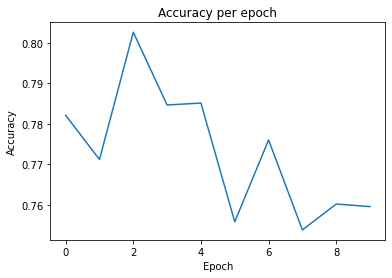

In [ ]:
f = plt.figure()
plt.plot(f1_history)
plt.title('Accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
f.savefig("accuracy.pdf", bbox_inches='tight')

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'epoch': 10.0,
 'eval_f1': 0.7595653982116863,
 'eval_loss': 0.9806757569313049,
 'eval_runtime': 59.6536,
 'eval_samples_per_second': 16.763,
 'eval_steps_per_second': 2.095}

In [ ]:
predictions = trainer.predict(full_eval_dataset)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


In [ ]:
pred = np.argmax(predictions.predictions, axis=1)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Text(0.5, 1.0, 'Confusion Matrix')

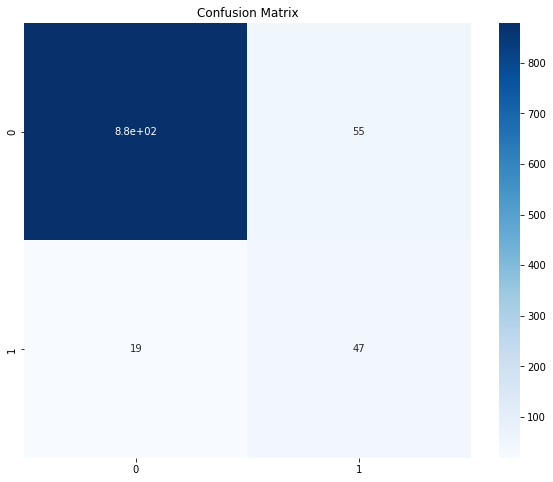

In [ ]:
from sklearn.metrics import confusion_matrix 
plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(pred.tolist(), full_eval_dataset['labels'])
s1 = sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')

In [ ]:
fig = s1.get_figure()
fig.savefig('Confusion_Matrix.pdf')  

In [ ]:
y_pred = trainer.predict(full_test_dataset)

***** Running Prediction *****
  Num examples = 3832
  Batch size = 8


In [ ]:
y_pred.predictions.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
df_preds=pd.DataFrame(y_pred.label_ids)
df_preds

""


In [ ]:
y = y_pred.predictions.argmax(axis=1)
y, len(y)

(array([0, 0, 0, ..., 0, 0, 0]), 3832)

In [ ]:
np.savetxt('y_pred.csv', y, fmt='%s')

In [ ]:
df_preds=pd.DataFrame(y)
df_preds.columns = ['label']
df_preds.sum(), df_preds

(label    229
 dtype: int64,       label
 0         0
 1         0
 2         0
 3         0
 4         0
 ...     ...
 3827      0
 3828      0
 3829      0
 3830      0
 3831      0
 
 [3832 rows x 1 columns])

In [ ]:
from google.colab import files
files.download('y_pred.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [ ]:
labels2file([[k] for k in list(df_preds['label'])], 'task1.txt')

In [ ]:
#Zip submission File
!zip submission.zip task1.txt

  adding: task1.txt (deflated 96%)


In [ ]:
# del trainer
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# mkdir -p /content/drive/MyDrive/full_roberta_lr5e-5/checkpoint-5500/

In [ ]:
# cp -r /content/full_roberta_lr5e-5/checkpoint-5500/ /content/drive/MyDrive/full_roberta_lr5e-5/checkpoint-5500/

In [ ]:
# import wandb
# wandb.init(project='pcl-binary')

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(df_pcl_valid['labels'].values, df_preds.values, target_names=['0','1']))

In [ ]:
# from sklearn.metrics import f1_score
# f1_score(df_pcl_valid['labels'].values, df_preds.values, average='macro')

In [ ]:
# df_pcl_valid['labels'].values[:10]